In [16]:
cd /content/drive/MyDrive/Colab Notebooks/cells

/content/drive/MyDrive/Colab Notebooks/cells


In [17]:
!pip install torchinfo

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.io import mmread


class RNA(Dataset):
    def __init__(self, data_file):
        # load the scRNA-seq data from the specified file
        self.data = torch.from_numpy(
            mmread(data_file).astype("float32").transpose().todense())
        print(self.data.shape)
        
    def __len__(self):
        # return the number of examples in the dataset
        return len(self.data)
    
    def __getitem__(self, index):
        # return the preprocessed data for the specified example
        library = self.data[index].sum(dim=-1)
        example = self.data[index]
        return example, library

        

# datasets: hcl, celegan, uc_epi, zfish_ep50_5226
# train_dataset = RNA("cells/data/hcl.mtx")
# train_dataset = RNA("data/zfish_ep50_5226.mtx")
train_dataset = RNA("cells/data/celegan.mtx")
train_loader = DataLoader(train_dataset, batch_size=2**12, shuffle=True) # 2**15


torch.Size([86024, 2766])


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

# ---------------------------
# - Variational Autoencoder -
# ---------------------------
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2) # mu + log_var
        )
        
        self.decoder = self.decode = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim))
        
    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=-1)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        return x_hat, mu, log_var

    def loss(self, x, x_hat, mu, log_var):
        recon_loss = F.mse_loss(x_hat, x, reduction="sum")
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return recon_loss, kl_div


dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = VAE(input_dim=next(iter(train_loader))[0].shape[-1], latent_dim=2).to(dev)
model.train()
opt = optim.Adam(model.parameters())

In [20]:
def train_vae(model, train_loader, num_epochs=150, kl_weight=4):
    kl_weight = 1

    loss_history = {'train_loss': [], 'recon_loss': [], 'kl_loss': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_recon_loss = 0.0
        running_kl_loss = 0.0

        for _, (data, library) in enumerate(train_loader):
            data = data.to(dev)
            library = library.to(dev)
            opt.zero_grad()
            x_hat, mu, log_var = model(data)
            x_hat = F.softmax(x_hat, dim=-1) * library.unsqueeze(-1)
            recon_loss, kl_div = model.loss(data, x_hat, mu, log_var)
            loss = recon_loss + kl_weight * kl_div
            loss.backward()
            opt.step()

            running_loss += loss.item()
            running_recon_loss += recon_loss.item()
            running_kl_loss += kl_div.item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_recon_loss = running_recon_loss / len(train_loader.dataset)
        epoch_kl_loss = running_kl_loss / len(train_loader.dataset)
        loss_history['train_loss'].append(epoch_loss)
        loss_history['recon_loss'].append(epoch_recon_loss)
        loss_history['kl_loss'].append(epoch_kl_loss)
        print(f"Epoch: {epoch}, Loss: {epoch_loss}, Recon Loss: {epoch_recon_loss}, KL Loss: {epoch_kl_loss}")
    
    return loss_history

vae_loss_hist = train_vae(model, train_loader, 100)

Epoch: 0, Loss: 26612.05279678945, Recon Loss: 26609.717068283633, KL Loss: 2.3359475774032443
Epoch: 1, Loss: 24289.28687383935, Recon Loss: 24287.39751960572, KL Loss: 1.889096815985413
Epoch: 2, Loss: 23380.654631129466, Recon Loss: 23379.228502865117, KL Loss: 1.4260615599573374
Epoch: 3, Loss: 22323.501555525203, Recon Loss: 22322.871208906818, KL Loss: 0.630262926524377
Epoch: 4, Loss: 21942.881872378093, Recon Loss: 21941.891546209124, KL Loss: 0.990250830477164
Epoch: 5, Loss: 21119.356861847784, Recon Loss: 21117.853136642825, KL Loss: 1.5036564952859566
Epoch: 6, Loss: 19284.66636817923, Recon Loss: 19282.382269228645, KL Loss: 2.284171900726591
Epoch: 7, Loss: 20220.290732410067, Recon Loss: 20217.85750011443, KL Loss: 2.4330699756446355
Epoch: 8, Loss: 18962.450044963833, Recon Loss: 18959.526454690335, KL Loss: 2.923549026530764
Epoch: 9, Loss: 20031.172437978792, Recon Loss: 20027.966939095484, KL Loss: 3.2055574993771043
Epoch: 10, Loss: 20437.41546245452, Recon Loss: 20

In [21]:
# Calculate reconstruction loss on "test" subset
model.eval()
test, test_lib = next(iter(DataLoader(train_dataset, batch_size=200, shuffle=False)))
test, test_lib = test.to(dev), test_lib.to(dev)
with torch.no_grad():
    x_hat, mu, log_var,= model(test)
    x_hat = F.softmax(x_hat, dim=-1) * test_lib.unsqueeze(-1)
    loss = F.mse_loss(x_hat, test, reduction='mean')
    print(f"Reconstruction loss: {loss.item():.4f}")

Reconstruction loss: 1.3369


In [22]:
# ------------------------
# - Gaussian Mixture VAE -
# ------------------------
from torchinfo import summary

class GMVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_clusters):
        super(GMVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.K = num_clusters
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim*num_clusters*2)
        )
        
        self.decoder = self.decode = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=-1)
        mu = mu.view(-1, self.K, self.latent_dim)
        log_var = log_var.view(-1, self.K, self.latent_dim)
        return mu, log_var

    def reparameterize(self, mu, log_var, temperature=1.0):
        eps = torch.randn_like(log_var)
        z = mu + torch.exp(log_var / 2) * eps
        # Gumbel-Softmax trick 
        gumbel_softmax_logits = (z.view(-1, self.K, self.latent_dim) / temperature).softmax(dim=-1) # (B, K, latent_dim)
        z = (gumbel_softmax_logits * z.view(-1, self.K, self.latent_dim)).sum(dim=1) # (B, latent_dim)
        return z, gumbel_softmax_logits


    def forward(self, x, temperature=1.0):
        x = x.view(-1, self.input_dim)
        mu, log_var = self.encode(x)
        z, gumbel_softmax_logits = self.reparameterize(mu, log_var, temperature=temperature)
        x_hat = self.decode(z)
        return x_hat, mu, log_var, z, gumbel_softmax_logits

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
gm = GMVAE(input_dim=next(iter(train_loader))[0].shape[-1], latent_dim=2, num_clusters=5).to(dev)
gm.train()
summary(gm, input_size=(2**12, 2766), device=dev)

Layer (type:depth-idx)                   Output Shape              Param #
GMVAE                                    [4096, 2766]              --
├─Sequential: 1-1                        [4096, 20]                --
│    └─Linear: 2-1                       [4096, 512]               1,416,704
│    └─ReLU: 2-2                         [4096, 512]               --
│    └─Linear: 2-3                       [4096, 256]               131,328
│    └─ReLU: 2-4                         [4096, 256]               --
│    └─Linear: 2-5                       [4096, 20]                5,140
├─Sequential: 1-2                        [4096, 2766]              --
│    └─Linear: 2-6                       [4096, 256]               768
│    └─ReLU: 2-7                         [4096, 256]               --
│    └─Linear: 2-8                       [4096, 512]               131,584
│    └─ReLU: 2-9                         [4096, 512]               --
│    └─Linear: 2-10                      [4096, 2766]           

In [27]:
summary(model, input_size=(2**12, 2766), device=dev)

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [4096, 2766]              --
├─Sequential: 1-1                        [4096, 4]                 --
│    └─Linear: 2-1                       [4096, 512]               1,416,704
│    └─ReLU: 2-2                         [4096, 512]               --
│    └─Linear: 2-3                       [4096, 256]               131,328
│    └─ReLU: 2-4                         [4096, 256]               --
│    └─Linear: 2-5                       [4096, 4]                 1,028
├─Sequential: 1-2                        [4096, 2766]              --
│    └─Linear: 2-6                       [4096, 256]               768
│    └─ReLU: 2-7                         [4096, 256]               --
│    └─Linear: 2-8                       [4096, 512]               131,584
│    └─ReLU: 2-9                         [4096, 512]               --
│    └─Linear: 2-10                      [4096, 2766]           

In [23]:
import torch.optim as optim
from tqdm import tqdm

def gmvae_loss(x, x_hat, mu, log_var, z, gumbel_softmax_logits, temperature=1.0):
    # Reconstruction loss
    recon_loss = F.mse_loss(x_hat, x, reduction='sum')

    # KL divergence loss
    kl_div = (torch.exp(log_var) + mu**2 - 1 - log_var).sum(dim=-1)
    kl_loss = torch.mean(torch.sum(gumbel_softmax_logits * kl_div.unsqueeze(-1), dim=-1))
    
    # Total loss
    loss = recon_loss + temperature * kl_loss
    
    return loss, recon_loss, kl_loss


def train(model, dataloader, num_epochs, lr=1e-3, weight_decay=1e-5, initial_temperature=1.0, final_temperature=0.5, device='cpu'): 
    model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_history = {'train_loss': [], 'recon_loss': [], 'kl_loss': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_recon_loss = 0.0
        running_kl_loss = 0.0

        # Compute the temperature for this epoch based on the linear annealing schedule
        temperature = max(initial_temperature - epoch * (initial_temperature - final_temperature) / (num_epochs - 1), final_temperature)
        for x, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch", leave=False):
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, mu, log_var, z, gumbel_softmax_logits = model(x, temperature=temperature)
            loss, recon_loss, kl_loss = gmvae_loss(x, x_hat, mu, log_var, z, gumbel_softmax_logits, temperature=temperature)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_recon_loss += recon_loss.item()
            running_kl_loss += kl_loss.item()

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_recon_loss = running_recon_loss / len(dataloader.dataset)
        epoch_kl_loss = running_kl_loss / len(dataloader.dataset)

        loss_history['train_loss'].append(epoch_loss)
        loss_history['recon_loss'].append(epoch_recon_loss)
        loss_history['kl_loss'].append(epoch_kl_loss)
        tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Recon loss: {epoch_recon_loss:.4f} - KL loss: {epoch_kl_loss:.4f}")
    model.eval()
    
    return loss_history

gm_loss_hist = train(gm, train_loader, num_epochs=100, initial_temperature=1.0, final_temperature=0.5, lr=1e-3, weight_decay=1e-5, device=dev)



Epoch 1/100 - Loss: 58083.6649 - Recon loss: 58083.4418 - KL loss: 0.2245


Epoch 2/100 - Loss: 17235.2857 - Recon loss: 17235.2653 - KL loss: 0.0206


Epoch 3/100 - Loss: 14364.0486 - Recon loss: 14364.0097 - KL loss: 0.0393


Epoch 4/100 - Loss: 11861.1155 - Recon loss: 11861.0566 - KL loss: 0.0598


Epoch 5/100 - Loss: 10796.2282 - Recon loss: 10796.1594 - KL loss: 0.0702


Epoch 6/100 - Loss: 10857.0230 - Recon loss: 10856.9541 - KL loss: 0.0709


Epoch 7/100 - Loss: 10897.6239 - Recon loss: 10897.5619 - KL loss: 0.0640


Epoch 8/100 - Loss: 10434.5676 - Recon loss: 10434.5098 - KL loss: 0.0600


Epoch 9/100 - Loss: 10233.4475 - Recon loss: 10233.3892 - KL loss: 0.0607


Epoch 10/100 - Loss: 9952.3929 - Recon loss: 9952.3268 - KL loss: 0.0691


Epoch 11/100 - Loss: 9698.4284 - Recon loss: 9698.3540 - KL loss: 0.0784


Epoch 12/100 - Loss: 9556.2228 - Recon loss: 9556.1413 - KL loss: 0.0863


Epoch 13/100 - Loss: 9366.9952 - Recon loss: 9366.9124 - KL loss: 0.0881


Epoch 14/100 - Loss: 9150.9786 - Recon loss: 9150.8876 - KL loss: 0.0974


Epoch 15/100 - Loss: 8958.4506 - Recon loss: 8958.3551 - KL loss: 0.1027


Epoch 16/100 - Loss: 8819.1051 - Recon loss: 8819.0025 - KL loss: 0.1109


Epoch 17/100 - Loss: 8792.3428 - Recon loss: 8792.2363 - KL loss: 0.1160


Epoch 18/100 - Loss: 8648.4724 - Recon loss: 8648.3616 - KL loss: 0.1211


Epoch 19/100 - Loss: 8561.6127 - Recon loss: 8561.5030 - KL loss: 0.1206


Epoch 20/100 - Loss: 8224.9711 - Recon loss: 8224.8629 - KL loss: 0.1196


Epoch 21/100 - Loss: 8043.7611 - Recon loss: 8043.6353 - KL loss: 0.1399


Epoch 22/100 - Loss: 7777.5197 - Recon loss: 7777.4013 - KL loss: 0.1324


Epoch 23/100 - Loss: 7599.0128 - Recon loss: 7598.8858 - KL loss: 0.1430


Epoch 24/100 - Loss: 7486.2427 - Recon loss: 7486.1178 - KL loss: 0.1413


Epoch 25/100 - Loss: 7370.8004 - Recon loss: 7370.6686 - KL loss: 0.1499


Epoch 26/100 - Loss: 7501.6477 - Recon loss: 7501.5211 - KL loss: 0.1450


Epoch 27/100 - Loss: 7343.0708 - Recon loss: 7342.9499 - KL loss: 0.1392


Epoch 28/100 - Loss: 7471.4352 - Recon loss: 7471.3138 - KL loss: 0.1406


Epoch 29/100 - Loss: 7421.7799 - Recon loss: 7421.6680 - KL loss: 0.1304


Epoch 30/100 - Loss: 7074.5400 - Recon loss: 7074.4246 - KL loss: 0.1352


Epoch 31/100 - Loss: 6969.7158 - Recon loss: 6969.5934 - KL loss: 0.1443


Epoch 32/100 - Loss: 6896.4606 - Recon loss: 6896.3370 - KL loss: 0.1466


Epoch 33/100 - Loss: 6833.5505 - Recon loss: 6833.4193 - KL loss: 0.1565


Epoch 34/100 - Loss: 6723.0671 - Recon loss: 6722.9362 - KL loss: 0.1571


Epoch 35/100 - Loss: 6670.0920 - Recon loss: 6669.9577 - KL loss: 0.1621


Epoch 36/100 - Loss: 6637.3813 - Recon loss: 6637.2442 - KL loss: 0.1664


Epoch 37/100 - Loss: 6502.0405 - Recon loss: 6501.8988 - KL loss: 0.1732


Epoch 38/100 - Loss: 6414.0204 - Recon loss: 6413.8739 - KL loss: 0.1802


Epoch 39/100 - Loss: 6309.7494 - Recon loss: 6309.5988 - KL loss: 0.1864


Epoch 40/100 - Loss: 6263.3807 - Recon loss: 6263.2274 - KL loss: 0.1908


Epoch 41/100 - Loss: 6164.6666 - Recon loss: 6164.5115 - KL loss: 0.1944


Epoch 42/100 - Loss: 6113.9577 - Recon loss: 6113.7974 - KL loss: 0.2021


Epoch 43/100 - Loss: 6099.2703 - Recon loss: 6099.1091 - KL loss: 0.2046


Epoch 44/100 - Loss: 6002.8290 - Recon loss: 6002.6663 - KL loss: 0.2078


Epoch 45/100 - Loss: 6018.6656 - Recon loss: 6018.4970 - KL loss: 0.2168


Epoch 46/100 - Loss: 5969.9801 - Recon loss: 5969.8199 - KL loss: 0.2073


Epoch 47/100 - Loss: 5890.8125 - Recon loss: 5890.6496 - KL loss: 0.2121


Epoch 48/100 - Loss: 5796.3524 - Recon loss: 5796.1866 - KL loss: 0.2175


Epoch 49/100 - Loss: 5715.3092 - Recon loss: 5715.1415 - KL loss: 0.2215


Epoch 50/100 - Loss: 5718.4554 - Recon loss: 5718.2858 - KL loss: 0.2253


Epoch 51/100 - Loss: 5653.0453 - Recon loss: 5652.8720 - KL loss: 0.2317


Epoch 52/100 - Loss: 5828.7379 - Recon loss: 5828.5710 - KL loss: 0.2250


Epoch 53/100 - Loss: 5757.2941 - Recon loss: 5757.1344 - KL loss: 0.2166


Epoch 54/100 - Loss: 5660.7189 - Recon loss: 5660.5477 - KL loss: 0.2338


Epoch 55/100 - Loss: 5668.7303 - Recon loss: 5668.5755 - KL loss: 0.2130


Epoch 56/100 - Loss: 5587.5778 - Recon loss: 5587.4213 - KL loss: 0.2167


Epoch 57/100 - Loss: 5533.4998 - Recon loss: 5533.3473 - KL loss: 0.2126


Epoch 58/100 - Loss: 5610.1337 - Recon loss: 5609.9809 - KL loss: 0.2146


Epoch 59/100 - Loss: 5528.7272 - Recon loss: 5528.5699 - KL loss: 0.2224


Epoch 60/100 - Loss: 5456.0181 - Recon loss: 5455.8679 - KL loss: 0.2139


Epoch 61/100 - Loss: 5464.6947 - Recon loss: 5464.5405 - KL loss: 0.2213


Epoch 62/100 - Loss: 5445.9529 - Recon loss: 5445.8050 - KL loss: 0.2138


Epoch 63/100 - Loss: 5399.4630 - Recon loss: 5399.3110 - KL loss: 0.2214


Epoch 64/100 - Loss: 5435.4464 - Recon loss: 5435.3022 - KL loss: 0.2114


Epoch 65/100 - Loss: 5398.6974 - Recon loss: 5398.5580 - KL loss: 0.2059


Epoch 66/100 - Loss: 5318.8223 - Recon loss: 5318.6814 - KL loss: 0.2096


Epoch 67/100 - Loss: 5318.1381 - Recon loss: 5317.9973 - KL loss: 0.2112


Epoch 68/100 - Loss: 5323.4246 - Recon loss: 5323.2831 - KL loss: 0.2139


Epoch 69/100 - Loss: 5310.1450 - Recon loss: 5310.0052 - KL loss: 0.2129


Epoch 70/100 - Loss: 5322.2750 - Recon loss: 5322.1383 - KL loss: 0.2098


Epoch 71/100 - Loss: 5263.7263 - Recon loss: 5263.5880 - KL loss: 0.2140


Epoch 72/100 - Loss: 5210.2702 - Recon loss: 5210.1313 - KL loss: 0.2165


Epoch 73/100 - Loss: 5182.8872 - Recon loss: 5182.7369 - KL loss: 0.2362


Epoch 74/100 - Loss: 5168.3975 - Recon loss: 5168.2585 - KL loss: 0.2202


Epoch 75/100 - Loss: 5139.8783 - Recon loss: 5139.7309 - KL loss: 0.2354


Epoch 76/100 - Loss: 5136.3567 - Recon loss: 5136.2161 - KL loss: 0.2265


Epoch 77/100 - Loss: 5120.4386 - Recon loss: 5120.2992 - KL loss: 0.2262


Epoch 78/100 - Loss: 5132.4934 - Recon loss: 5132.3490 - KL loss: 0.2362


Epoch 79/100 - Loss: 5171.9089 - Recon loss: 5171.6542 - KL loss: 0.4202


Epoch 80/100 - Loss: 5163.7481 - Recon loss: 5163.6171 - KL loss: 0.2179


Epoch 81/100 - Loss: 5138.1152 - Recon loss: 5137.9824 - KL loss: 0.2227


Epoch 82/100 - Loss: 5196.0682 - Recon loss: 5195.9276 - KL loss: 0.2381


Epoch 83/100 - Loss: 5073.0510 - Recon loss: 5072.9237 - KL loss: 0.2171


Epoch 84/100 - Loss: 5025.9417 - Recon loss: 5025.8158 - KL loss: 0.2166


Epoch 85/100 - Loss: 4997.1667 - Recon loss: 4997.0395 - KL loss: 0.2211


Epoch 86/100 - Loss: 4978.2216 - Recon loss: 4978.0893 - KL loss: 0.2317


Epoch 87/100 - Loss: 4992.4864 - Recon loss: 4992.3572 - KL loss: 0.2284


Epoch 88/100 - Loss: 4989.5115 - Recon loss: 4989.3130 - KL loss: 0.3542


Epoch 89/100 - Loss: 4962.2419 - Recon loss: 4962.1153 - KL loss: 0.2279


Epoch 90/100 - Loss: 4940.7956 - Recon loss: 4940.6344 - KL loss: 0.2929


Epoch 91/100 - Loss: 4947.9759 - Recon loss: 4947.8517 - KL loss: 0.2277


Epoch 92/100 - Loss: 4926.9801 - Recon loss: 4926.8550 - KL loss: 0.2315


Epoch 93/100 - Loss: 4928.4695 - Recon loss: 4928.3461 - KL loss: 0.2305


Epoch 94/100 - Loss: 4909.8979 - Recon loss: 4909.7759 - KL loss: 0.2299


Epoch 95/100 - Loss: 4951.0821 - Recon loss: 4950.9617 - KL loss: 0.2293


Epoch 96/100 - Loss: 4874.0830 - Recon loss: 4873.9567 - KL loss: 0.2428


Epoch 97/100 - Loss: 4811.9611 - Recon loss: 4811.8394 - KL loss: 0.2363


Epoch 98/100 - Loss: 4807.7735 - Recon loss: 4807.6526 - KL loss: 0.2370


Epoch 99/100 - Loss: 4797.3958 - Recon loss: 4797.2719 - KL loss: 0.2453


Epoch 100/100 - Loss: 4812.8915 - Recon loss: 4812.7689 - KL loss: 0.2450


In [24]:
# Calculate reconstruction loss on the complete dataset
model.eval()

with torch.no_grad():
    x_hat, mu, log_var, z, gumbel_softmax_logits = gm(test, temperature=0.5)
    loss = F.mse_loss(x_hat, test, reduction='mean')
    print(f"Reconstruction loss: {loss.item():.4f}")

Reconstruction loss: 1.4161


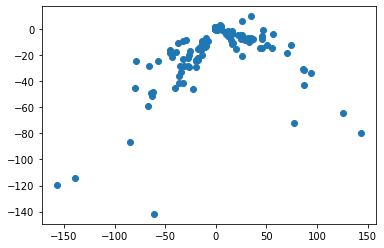

In [25]:
from matplotlib import pyplot as plt

zt = z.cpu().detach().numpy()

plt.scatter(zt[:,0], zt[:,1])

In [26]:
asdsa
import time
import pickle

recon_loss = loss_history['recon_loss'][-1]
timestamp = time.strftime("%Y%m%d-%H%M%S")
model_path = f"models/gmvae_{timestamp}_{recon_loss}.pt"
loss_history_path = f"loss_history/gmvae_{timestamp}_{recon_loss}.pkl"

torch.save(gm.state_dict(), gm)
with open(loss_history_path, 'wb') as f:
    pickle.dump(loss_history, f)

## LOAD MODEL AND LOSS HISTORY
# model_path = "models/gmvae_20210104-174210.pt"
# loss_history_path = "loss_history/gmvae_20210104-174210.pkl"

# model.load_state_dict(torch.load(model_path))
# with open(loss_history_path, 'rb') as f:
#     loss_history = pickle.load(f)


NameError: ignored

In [ ]:
# z = model.reparameterize(*model.encoder(test))

# for i in range(z.shape[1]):
#     model.decoder.zero_grad()
#     leaf = z[0].detach().requires_grad_()
#     out = model.decoder(z[0])[i]
#     out.retain_grad()
#     out.backward(retain_graph=True)
#     gene_gradients.append(out.grad.clone().detach())


# G = torch.stack(gene_gradients)

# G

In [ ]:
from functorch import jacfwd, vmap

def jac(f, z):
    # composed with vmap for batched Jacobians
    return vmap(jacfwd(f))(z)
    
def jac_robust(f, z):
    # alternative jac if experiencing crashes 
    batch_size, z_dim = z.size()
    v = torch.eye(z_dim).unsqueeze(0).repeat(batch_size, 1, 1).view(-1, z_dim).to(z)
    z = z.repeat(1, z_dim).view(-1, z_dim)
    return torch.autograd.functional.jvp(f, z, v=v)[1].view(batch_size, z_dim, -1).permute(0, 2, 1)

# gene "correlation" matrix C
def C_matrix(f, z, normalize=False):
    '''
    f:      model.decode: (b, m) -> (b, n) 
    z:      torch.tensor whose size = (b, m) (keep b low for memory)
    out:    torch.tensor whose size = (b, n, n)
    '''
    J = jac(f, z)

    # J @ J.T on batch 
    if normalize:
        return torch.bmm(J, J.transpose(1,2)) / J.norm(p=2, dim=2).unsqueeze(-1)
    else:
        return torch.bmm(J, J.transpose(1,2))

# jacrev: 1.45s
# jacfwd: 80-90ms 
# jvp:    85-92ms 

## Trajectories

In [ ]:
def get_Riemannian_metric(f, z, create_graph=False): #J.T @ J instead! 
    J = jac_robust(f, z)
    out = torch.einsum('nij,nik->njk', J, J)
    return out


In [ ]:
def compute_geodesic(z1, z2, pretrained_model, get_Riemannian_metric, num_discretization=100):
    '''
    z1 : torch.tensor whose size = (1, 2)
    z1 : torch.tensor whose size = (1, 2)
    out: torch.tensor whose size = (num_discretization, 2)
    '''
    from scipy.optimize import minimize
    class GeodesicFittingTool():
        def __init__(self, z1, z2, z_init, pretrained_model, get_Riemannian_metric, num_discretization, method, device=f"cuda:{0}"):
            self.z1 = z1
            self.z2 = z2
            self.pretrained_model = pretrained_model
            self.get_Riemannian_metric = get_Riemannian_metric
            self.num_discretization = num_discretization
            self.delta_t = 1/(num_discretization-1)
            self.device = device
            self.method = method
            self.z_init_input = z_init
            self.initialize()
            
        def initialize(self):
            self.z_init= self.z1.squeeze(0)
            self.z_final= self.z2.squeeze(0)
            dim = self.z_final.size(0)
            self.init_z = self.z_init_input.detach().cpu().numpy()
            self.z_shape = self.init_z.shape
            self.init_z_vec = self.init_z.flatten()

        def geodesic_loss(self, z): 
            z_torch = torch.tensor(z.reshape(self.z_shape), dtype=torch.float32).to(self.device)
            z_extended = torch.cat([self.z_init.unsqueeze(0), z_torch, self.z_final.unsqueeze(0)], dim=0)
            G_ = self.get_Riemannian_metric(self.pretrained_model.decode, z_extended[:-1])
            delta_z = (z_extended[1:, :]-z_extended[:-1, :])/(self.delta_t)
            loss = torch.einsum('ni, nij, nj -> ', delta_z, G_, delta_z) * self.delta_t
            return loss.item()
        
        def jac(self, z):
            z_torch = torch.tensor(z.reshape(self.z_shape), dtype=torch.float32).to(self.device)
            z_torch.requires_grad = True
            z_extended = torch.cat([self.z_init.unsqueeze(0), z_torch, self.z_final.unsqueeze(0)], dim=0)
            G_ = self.get_Riemannian_metric(self.pretrained_model.decode, z_extended[:-1], create_graph=True)
            delta_z = (z_extended[1:, :]-z_extended[:-1, :])/(self.delta_t)
            loss = torch.einsum('ni, nij, nj -> ', delta_z, G_, delta_z) * self.delta_t
            loss.backward()
            z_grad = z_torch.grad
            return z_grad.detach().cpu().numpy().flatten()

        def callback(self, z):
            self.Nfeval += 1
            return print('{} th loss : {}'.format(self.Nfeval, self.geodesic_loss(z)))
            
        def BFGS_optimizer(self, callback=False, maxiter=1000):
            self.Nfeval = 0
            z0 = self.init_z_vec
            if callback == True:
                call = self.callback
            else:
                call = None
            res = minimize(
                self.geodesic_loss, 
                z0, 
                callback=call, 
                method=self.method,
                jac = self.jac,
                options = {
                    'gtol': 1e-10, 
                    'eps': 1.4901161193847656e-08, 
                    'maxiter': maxiter, 
                    'disp': True, 
                    'return_all': False, 
                    'finite_diff_rel_step': None}
                )
            self.res = res

    z12_linear_curve = torch.cat([z1.to(device) + (z2.to(device) - z1.to(device)) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)
    
    tool = GeodesicFittingTool(z1, z2, z12_linear_curve[1:-1], pretrained_model, get_Riemannian_metric, num_discretization, 'BFGS', device=device)
    tool.BFGS_optimizer()
    z_torch = torch.tensor(tool.res['x'].reshape(tool.z_shape), dtype=torch.float32).to(device)
    out = torch.cat([tool.z_init.unsqueeze(0), z_torch, tool.z_final.unsqueeze(0)], dim=0)
    return out


In [ ]:
z1 = torch.tensor([[-1, 1]], dtype=torch.float32) 
z2 = torch.tensor([[0.6, -1.2]], dtype=torch.float32) 

num_discretization = 100
z12_geodesic_curve = compute_geodesic(
    z1.to(device), 
    z2.to(device), 
    pretrained_model, 
    get_Riemannian_metric, 
    num_discretization=num_discretization
)
assert z12_geodesic_curve.size() == torch.Size([num_discretization, 2])


In [ ]:
L12 = compute_length_of_curve(
    z12_geodesic_curve, pretrained_model, get_Riemannian_metric)
L12


In [ ]:
z12_linear_curve = torch.cat([z1.to(device) + (z2.to(device) - z1.to(device)) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)

latent_embeddings = pretrained_model.encode(
    train_ds.data.to(device)
    ).detach().cpu().numpy()

z_scale = np.minimum(
    np.max(latent_embeddings, axis=0), 
    np.min(latent_embeddings, axis=0)
)
labels = torch.unique(train_ds.targets)

f = plt.figure(figsize=(7, 7))
plt.title('Latent space embeddings')
for label in labels:
    classwise_le = latent_embeddings[train_ds.targets == label]
    plt.scatter(
        classwise_le[:200, 0], 
        classwise_le[:200, 1], 
        label=label.item(), s=5)

plt.scatter(z1[0, 0], z1[0, 1], c='tab:red', marker='s')
plt.scatter(z2[0, 0], z2[0, 1], c='tab:green', marker='s')

plt.scatter(z12_linear_curve[:, 0].detach().cpu(), z12_linear_curve[:, 1].detach().cpu(), s=10, c='tab:gray')
plt.scatter(z12_geodesic_curve[:, 0].detach().cpu(), z12_geodesic_curve[:, 1].detach().cpu(), s=10, c='tab:pink')

plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.legend()
plt.show()
